# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [ ]:
# TODO: Install any packages that you might need
!pip install smdebug torch torchvision ipywidgets

In [2]:
# TODO: Import any packages that you might need
from tqdm import tqdm
import argparse
import json
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils import data

import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
import boto3

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [3]:
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))



In [4]:
download_and_arrange_data()

100%|██████████| 1228/1228 [01:34<00:00, 12.94it/s]


100%|██████████| 2299/2299 [03:03<00:00, 12.51it/s]


100%|██████████| 2666/2666 [03:38<00:00, 12.22it/s]


100%|██████████| 2373/2373 [03:05<00:00, 12.82it/s]


100%|██████████| 1875/1875 [02:25<00:00, 12.89it/s]


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [6]:
# Resizing all images beforehand to reduce training time
SOURCE_BASE = "train_data/"
TARGET_BASE_TRAIN = "resized_data/train/"
TARGET_BASE_VAL = "resized_data/val/"
TRAIN_IMAGE_SIZE = 300 # will be cropped for augmentation
VAL_IMAGE_SIZE = 300 # will be cropped for augmentation
SEED = 43
random.seed(SEED) # setting seed to have consistent split over time, for reproducibility
np.random.seed(SEED) 

train_split = 0.85

if not os.path.isdir(TARGET_BASE_TRAIN):
    os.makedirs(TARGET_BASE_TRAIN)

if not os.path.isdir(TARGET_BASE_VAL):
    os.makedirs(TARGET_BASE_VAL)
    
classes = os.listdir(SOURCE_BASE)

for class_name in tqdm(classes):
        
        images = os.listdir(SOURCE_BASE+class_name)
        
        train_images = images[:int(train_split*len(images))]
        val_images = images[int(train_split*len(images)):]
        
        for img_name in train_images:
            if ".jpg" not in img_name:
                continue
            source = SOURCE_BASE + class_name + '/' + img_name
            target = TARGET_BASE_TRAIN + class_name + '/' + img_name
            resized_im = transforms.Resize((TRAIN_IMAGE_SIZE,TRAIN_IMAGE_SIZE))(Image.open(source).convert('RGB'))
            if not os.path.isdir(os.path.dirname(target)):
                os.makedirs(os.path.dirname(target))
            resized_im.save(target)
            os.remove(source)
            del resized_im
        for img_name in val_images:
            if ".jpg" not in img_name:
                continue
            source = SOURCE_BASE + class_name + '/' + img_name
            target = TARGET_BASE_VAL + class_name + '/' + img_name
            resized_im = transforms.Resize((VAL_IMAGE_SIZE,VAL_IMAGE_SIZE))(Image.open(source).convert('RGB'))
            if not os.path.isdir(os.path.dirname(target)):
                os.makedirs(os.path.dirname(target))
            resized_im.save(target)
            os.remove(source)
            del resized_im

100%|██████████| 5/5 [00:47<00:00,  9.46s/it]


class samples:


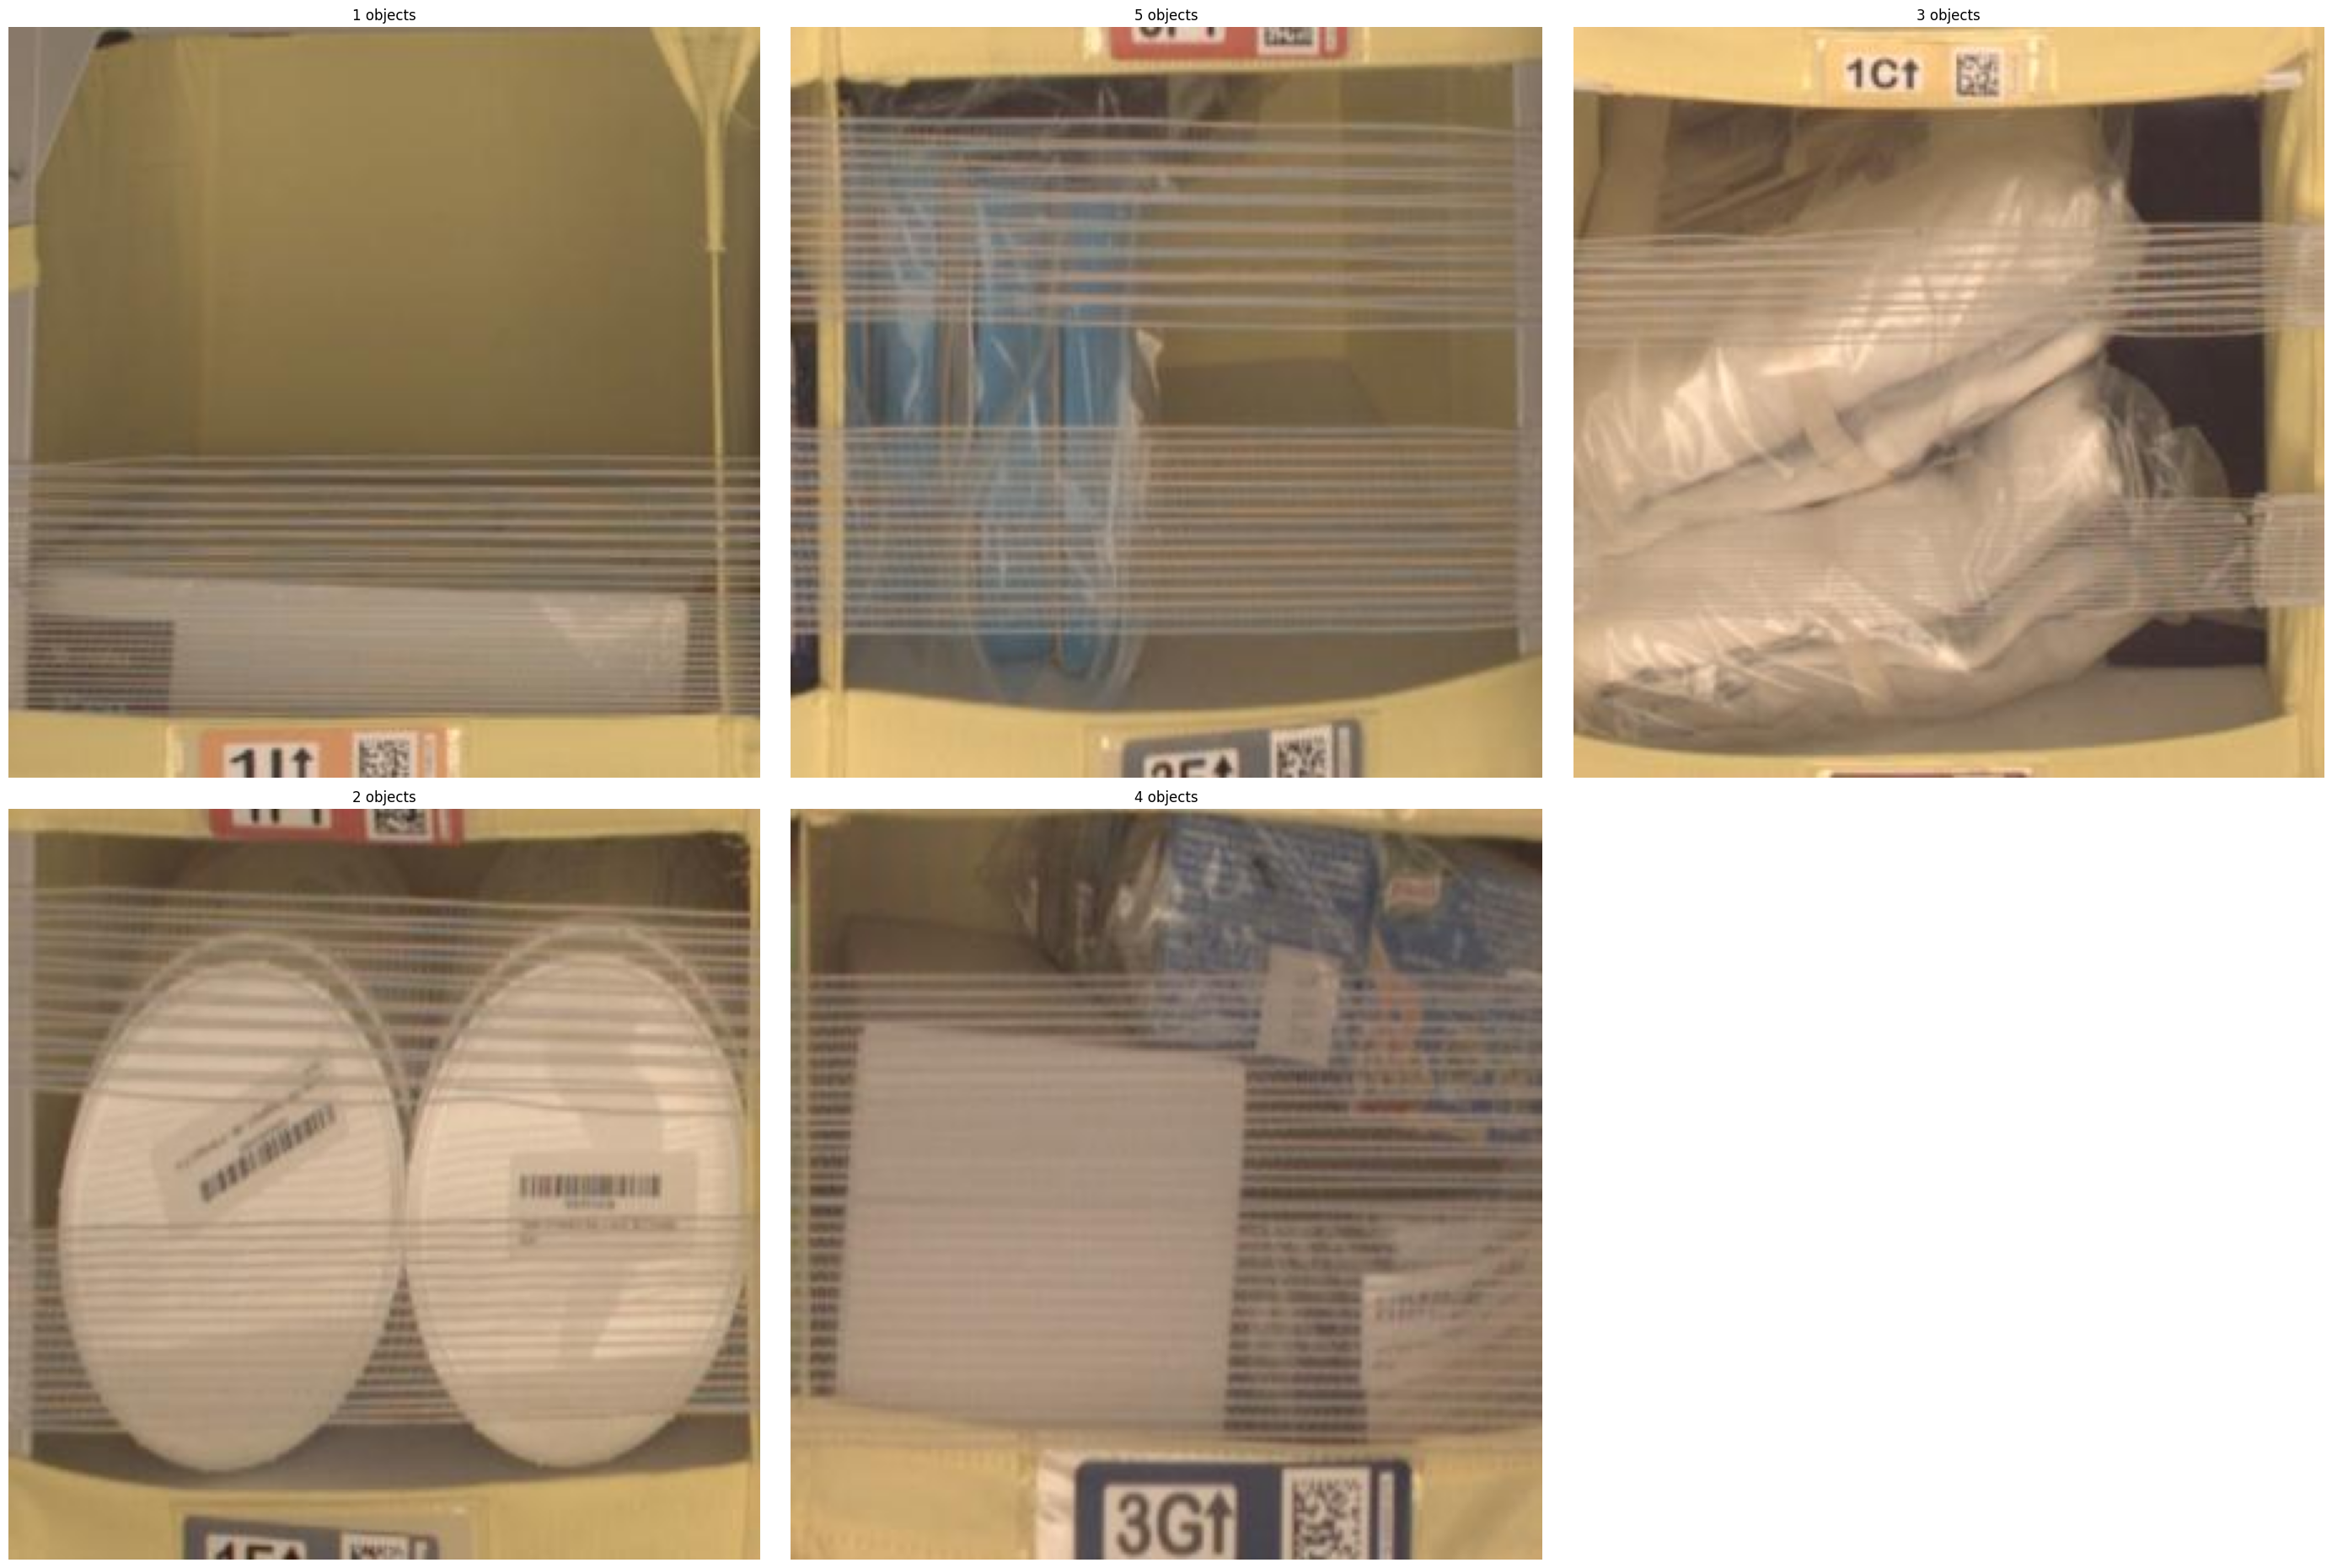

In [9]:
#TODO: Perform any data cleaning or data preprocessing
import random
from math import ceil

N = len(train_classes)
n = ceil(N**0.5)

train_path = "resized_data/train/"
train_classes = os.listdir(train_path)

plt.figure(figsize=(28,28))
for idx, class_name in enumerate(train_classes,start=1):
    class_path = train_path+"/"+class_name
    image_name = random.choice([f for f in os.listdir(class_path) if ".jpg" in f])
    
    plt.subplot(n,n,idx)
    im = plt.imread(class_path+"/"+image_name)
    plt.imshow(im)
    plt.title(class_name + " objects")
    plt.axis('off')

print("class samples:")
plt.tight_layout()
plt.savefig("class_samples.png")
plt.show()

In [ ]:
#TODO: Upload the data to AWS S3
!aws s3 cp 'resized_data' s3://mleng-nd-capstone/ --recursive

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [21]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
hyperparameters = {
    'lr':0.0001,
    'batch-size':128,
    'test-batch-size':128,
    'epochs':10,

}


In [22]:
#TODO: Create your training estimator
estimator = PyTorch(
    entry_point="train.py",
    base_job_name='object-count-classifier',
    role=get_execution_role(),
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3',
    output_path = "s3://mleng-nd-capstone/training-output/",
    hyperparameters=hyperparameters
)

In [23]:
# TODO: Fit your estimator
estimator.fit(
    {
        "train": "s3://mleng-nd-capstone/train/",
        "val":"s3://mleng-nd-capstone/val/"
    },
    wait=True
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: object-count-classifier-2023-04-17-06-05-44-899


2023-04-17 06:05:45 Starting - Starting the training job...
2023-04-17 06:05:59 Starting - Preparing the instances for training......
2023-04-17 06:06:53 Downloading - Downloading input data...
2023-04-17 06:07:23 Training - Downloading the training image......
2023-04-17 06:08:34 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-17 06:08:45,644 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2023-04-17 06:08:45,672 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-17 06:08:45,675 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-17 06:08:45,843 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2023-04-17 06:08:45,844 sagemaker-containers INFO     Generating setup.cfg
2023

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [24]:
#TODO: Create your hyperparameter search space

hyperparameters = {
    "test-batch-size": "128",
    "batch-size": "128",
    "epochs": "6",
}
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.01),
    "head_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

In [31]:
#TODO: Create your training estimator

objective_metric_name = "Average Test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Average Test loss", "Regex": "Average Test loss: ([0-9\\.]+)"}]


hpo_estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "hyper-param-tuning",
    role = get_execution_role(),
    instance_count = 1,
    instance_type = "ml.g4dn.xlarge", #"ml.m5.large"
    hyperparameters = hyperparameters,
    framework_version = "1.8",
    py_version = "py36",
    output_path = "s3://mleng-nd-capstone/hpo-output/"
)


tuner = HyperparameterTuner(
    hpo_estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs = 2,
    max_parallel_jobs = 2,
    objective_type = objective_type,
)

In [34]:
# TODO: Fit your estimator
tuner.fit({"train": "s3://mleng-nd-capstone/train/",
              "val":"s3://mleng-nd-capstone/val/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230417-0703


.............................................................................................................................................................................................................................................................................................................!


In [35]:
# TODO: Find the best hyperparameters
# tuner_job_name = ""
# tuner = HyperparameterTuner.attach(tuner_job_name)
best_estimator = tuner.best_estimator()

# best hyperparameters
best_hyperparameters = best_estimator.hyperparameters()
best_hyperparameters


2023-04-17 07:25:15 Starting - Preparing the instances for training
2023-04-17 07:25:15 Downloading - Downloading input data
2023-04-17 07:25:15 Training - Training image download completed. Training in progress.
2023-04-17 07:25:15 Uploading - Uploading generated training model
2023-04-17 07:25:15 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"Average Test loss"',
 'batch-size': '"128"',
 'epochs': '"6"',
 'head_size': '"512"',
 'lr': '0.006747601467379431',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hyper-param-tuning-2023-04-17-07-03-30-504"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://mleng-nd-capstone/hyper-param-tuning-2023-04-17-07-03-30-504/source/sourcedir.tar.gz"',
 'test-batch-size': '"128"'}

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [36]:
# TODO: Set up debugging and profiling rules and hooks

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
]


hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "10",
        "eval.save_interval": "5"
    },
    collection_configs = [
        CollectionConfig(
            name = "CrossEntropyLoss_output_0",
            parameters = {
              "include_regex": "CrossEntropyLoss_output_0",
              "train.save_interval": "10",
              "eval.save_interval": "1"
            }
        )
    ]
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [47]:
# TODO: Create and fit an estimator
hyperparameters = { "test-batch-size": "128",
                   "epochs": 8,
                   "batch-size": 128,
                   "lr": best_hyperparameters['lr'],
                  "head_size": int(best_hyperparameters['head_size'].replace('"',''))
                  }

estimator = PyTorch(
    entry_point='train.py',
    base_job_name='obj-count-clf-with-profiler',
    role=get_execution_role(),
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
    output_path = "s3://mleng-nd-capstone/profiler-output/",
)

In [ ]:
estimator.fit(
    {
        "train": "s3://mleng-nd-capstone/train/",
        "val":"s3://mleng-nd-capstone/val/"
    },
    wait=True
)

In [49]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-04-17 08:37:06.194 ip-172-16-184-146.ec2.internal:24959 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-04-17 08:37:06.283 ip-172-16-184-146.ec2.internal:24959 INFO s3_trial.py:42] Loading trial debug-output at path s3://mleng-nd-capstone/profiler-output/obj-count-clf-with-profiler-2023-04-17-08-07-05-390/debug-output
[2023-04-17 08:37:06.648 ip-172-16-184-146.ec2.internal:24959 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4790 more expected)', IncompleteRead(0 bytes read, 4790 more expected)) while reading s3://mleng-nd-capstone/profiler-output/obj-count-clf-with-profiler-2023-04-17-08-07-05-390/debug-output/index/000000000/000000000159_worker_0.json . Will retry now


In [50]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data", vals_train)
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data", vals_eval)

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show();

[2023-04-17 08:37:18.561 ip-172-16-184-146.ec2.internal:24959 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-04-17 08:37:19.588 ip-172-16-184-146.ec2.internal:24959 INFO trial.py:210] Loaded all steps
loaded TRAIN data [array(1.5998944, dtype=float32), array(1.8307892, dtype=float32), array(1.6965811, dtype=float32), array(1.5445247, dtype=float32), array(1.5410322, dtype=float32), array(1.583473, dtype=float32), array(1.5390296, dtype=float32), array(1.5592892, dtype=float32), array(1.5510312, dtype=float32), array(1.5121934, dtype=float32), array(1.5557609, dtype=float32), array(1.5057566, dtype=float32), array(1.5169524, dtype=float32), array(1.5035974, dtype=float32), array(1.5019562, dtype=float32), array(1.5416048, dtype=float32), array(1.4760153, dtype=float32), array(1.4822797, dtype=float32), array(1.4746133, dtype=float32), array(1.4976548, dtype=float32), array(1.4784948, dtype=float32), array(1.487986, dtype=float32), array(1.7117842, dty

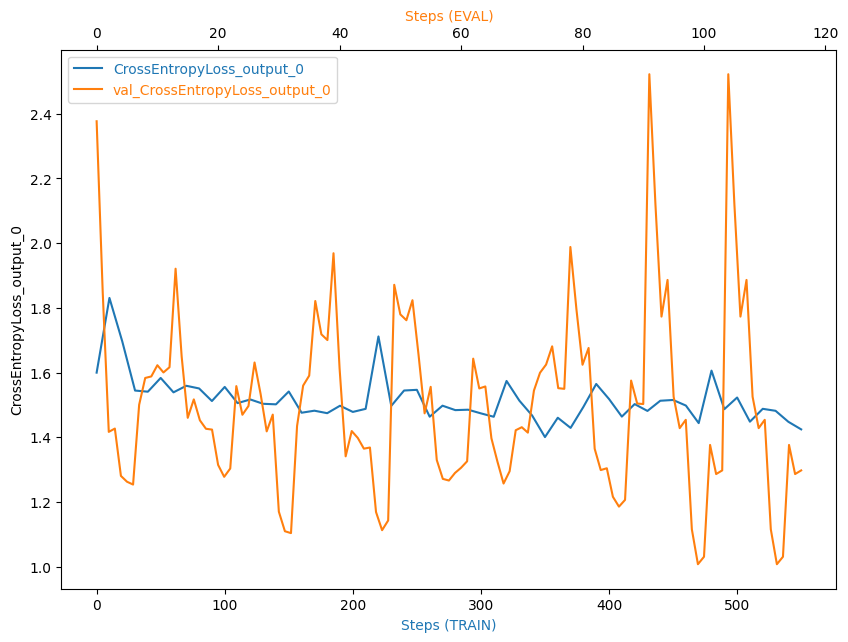

In [51]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [52]:
# TODO: Display the profiler output
import os

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")
!aws s3 ls {rule_output_path} --recursive

## copy to local
!aws s3 cp {rule_output_path} ./ --recursive

You will find the profiler report in s3://mleng-nd-capstone/profiler-output/obj-count-clf-with-profiler-2023-04-17-08-07-05-390/rule-output
2023-04-17 08:36:30     361692 profiler-output/obj-count-clf-with-profiler-2023-04-17-08-07-05-390/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-04-17 08:36:30     208603 profiler-output/obj-count-clf-with-profiler-2023-04-17-08-07-05-390/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-04-17 08:36:25        192 profiler-output/obj-count-clf-with-profiler-2023-04-17-08-07-05-390/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-04-17 08:36:25      68091 profiler-output/obj-count-clf-with-profiler-2023-04-17-08-07-05-390/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-04-17 08:36:25        126 profiler-output/obj-count-clf-with-profiler-2023-04-17-08-07-05-390/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-0

In [53]:
import IPython

profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]


IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

model_location=estimator.model_data
print(model_location)### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [54]:
model_location=estimator.model_data
print(model_location)

s3://mleng-nd-capstone/profiler-output/obj-count-clf-with-profiler-2023-04-17-08-07-05-390/output/model.tar.gz


In [66]:
# TODO: Deploy your model to an endpoint
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )


pytorch_model = PyTorchModel(model_data=model_location, role=get_execution_role(), entry_point='inference.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)        

In [67]:

predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker:Creating model with name: pytorch-inference-2023-04-17-08-46-49-990
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-04-17-08-46-50-660
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-04-17-08-46-50-660


-----!

In [76]:
# TODO: Run an prediction on the endpoint

from PIL import Image
import io

def image_to_byte_array(image:Image):
    imgByteArr = io.BytesIO()
    image.save(imgByteArr, format=image.format)
    imgByteArr = imgByteArr.getvalue()
    return imgByteArr

img = Image.open("resized_data/val/3/00722.jpg", mode='r')
img_bytes = image_to_byte_array(img)
type(img_bytes)

bytes

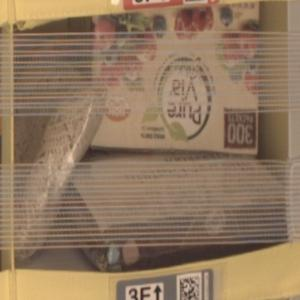

In [77]:
img

In [78]:
pred = predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
pred[0]

[-1.319909691810608,
 -0.04901547729969025,
 0.3014374375343323,
 0.1349669247865677,
 -0.3881283402442932]

In [81]:
print(f"Actual: 3 | predicted: {np.argmax(pred, 1).item()+1}")

Actual: 3 | predicted: 3


In [82]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-04-17-08-46-50-660
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-04-17-08-46-50-660


### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

### Cost Analysis

so far the training jobs was done on `ml.g4dn.xlarge` instances which are the most cost-efficient instances among accelerated computing instances ($0.736/hr). THis allows us to utilize GPUs for training the models while controlling the costs of trainng jobs.
We could always upgrade to more powerful GPU instances for longer trainings considering the available budget for the project.

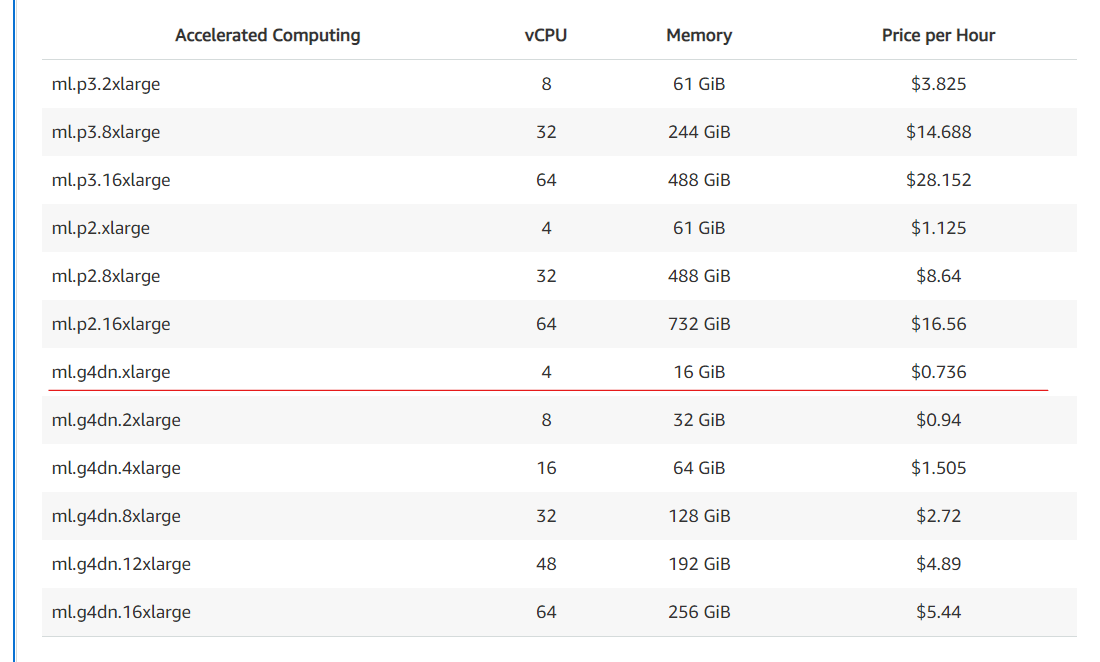

And for inference, the endpoint deployed on `'ml.m5.large'` ($0.11/hr) instance to incur minimum cost, knowing the traffic for this project is very low. However we could use faster instances for higher levels of traffic conssidering the available budget. we can also take advantage of autoscaling for higher traffics.

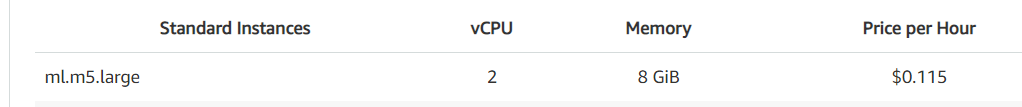

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances

multi_instance = PyTorch(
    base_job_name="multi-inst-obj-count-clf",
    entry_point="train.py",
    role=role,
    framework_version="1.4.0",
    py_version="py3",
    instance_count=4,
    instance_type="ml.g4dn.2xlarge",
    hyperparameters=hyperparameters,
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)
multi_instance.fit({"train": "s3://mleng-nd-capstone/train/",
              "val":"s3://mleng-nd-capstone/val/"}, wait=True)

In [84]:
!zip profiler.zip ProfilerReport

updating: ProfilerReport/ (stored 0%)
